In [48]:
import os
import sys
import shutil
import glob
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from itertools import permutations
from multiprocessing import Pool
import matplotlib.mlab as mlab

In [26]:
def transform_gene_id():
    os.chdir("/data5/galaxy/project/data/promoter/human/3k_3k")
    df = pd.read_table("promoter.bed", sep="\t", header=None, names=["chr", "s", "e", "len", "str", "ENTREZID"])
    df_trans = pd.read_table("bitr.txt", sep="\t")
    df_res = df.merge(df_trans, on="ENTREZID", how="left")[["chr", "s", "e", "ENSEMBL", "len", "str"]]
    # df_res = df_res[(df_res["ENSEMBL"] != "")]
    df_res = df_res.replace("", np.nan).dropna()
    df_res.sort_values(["chr", "s"]).to_csv("gene_promoter.bed", sep="\t", header=False, index=False)

In [27]:
os.chdir("/data5/galaxy/shell_dir/2018_3_17/chip_seq_pipeline/overlap_enrich/character_promoter/compre_analysis")
!python 04_statistics_motif_count.py
# 15317 high_CpG.bed
# 9783 low_CpG.bed

enrich CpG in promoter
WARNING. chromosome (chr11_JH159136v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_JH159136v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_JH159136v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_JH159137v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_KI270903v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_KI270903v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr11_KI270903v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr12_KI270904v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr12_KI270904v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr12_KI270904v1_alt) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr14_GL000194v1_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr15_G

In [93]:
m6a_dir = "/data5/galaxy/project/methyl_m6a/data/diff_m6a_peak/macs2_bdgdiff/combination/"
expre_dir = "/data5/galaxy/project/expression/DESeq2/"
names = get_genes_by_CpG()
print(len(names))
subdir_list = ["heart_vs_brain", "kid_vs_brain", "lung_vs_brain", "heart_vs_kid", "lung_vs_heart", "lung_vs_kid"]
for sub_dir in subdir_list:
    print("##################################\n%s" % sub_dir)
    df_methyl_up, df_methyl_common, df_methyl_down = foldchange_of_methylation(sub_dir)
    df_m6a, df_m6a_up, df_m6a_common, df_m6a_down = class_m6a_by_diffPeak(os.path.join(m6a_dir, sub_dir))
#     print(len(df_m6a))
#     print(df_m6a.head())
    methyl_list = [df_methyl_up, df_methyl_common, df_methyl_down]
    term_list = ["methyl_up", "methy_remained", "methy_down"]
    term_dict = dict(zip(term_list, methyl_list))
    for term, df_methyl in term_dict.items():
        print("########## %s ##########" % term)
        # high CpG and FC > 1
#         print(df_methyl.head())
        df_CpG = df_methyl[df_methyl["name"].isin(names)]
#         df_CpG.to_csv("/data5/galaxy/shell_dir/2018_3_17/jupyter_shell/test_1.txt", index=False)
#         df_m6a.to_csv("/data5/galaxy/shell_dir/2018_3_17/jupyter_shell/test_3.txt", index=False)
        df = df_CpG.merge(df_m6a, on="name", how="left").dropna().drop_duplicates()
#         df.to_csv("/data5/galaxy/shell_dir/2018_3_17/jupyter_shell/test_2.txt", index=False)
#         print(len(df_methyl), len(df_CpG), len(df))
        each_type_expre(df, df_m6a_up, df_m6a_common, df_m6a_down)
#         print(len(df))
    #     df_gene_up, df_gene_down = class_gene_by_diffexpre(os.path.join(expre_dir, "%s.csv" % sub_dir))
    #     df_coor = filter_each_row_by_expression(df, df_gene_up, df_gene_down)
    #     print(len(df_coor))

14436
##################################
heart_vs_brain
########## methyl_up ##########
m6a up	m6a common	m6a down
0.606897	0.222414	0.170690
########## methy_remained ##########
m6a up	m6a common	m6a down
0.571194	0.258503	0.170303
########## methy_down ##########
m6a up	m6a common	m6a down
0.610738	0.214765	0.174497
##################################
kid_vs_brain
########## methyl_up ##########
m6a up	m6a common	m6a down
0.485348	0.375458	0.139194
########## methy_remained ##########
m6a up	m6a common	m6a down
0.500000	0.336397	0.163603
########## methy_down ##########
m6a up	m6a common	m6a down
0.576547	0.270358	0.153094
##################################
lung_vs_brain
########## methyl_up ##########
m6a up	m6a common	m6a down
0.644800	0.225600	0.129600
########## methy_remained ##########
m6a up	m6a common	m6a down
0.672430	0.200853	0.126717
########## methy_down ##########
m6a up	m6a common	m6a down
0.675090	0.194946	0.129964
##################################
heart_vs_kid
#######

In [69]:
def get_genes_by_CpG():
    cutoff = 0.35
    CpG_high = "/data5/galaxy/project/CpG_m6a_motif/fasta_seq/high_CpG.bed"
    for in_bed in [CpG_high]:
        df = pd.read_table(in_bed, sep="\t", header=None)
#         df_subset = df[df.iloc[:, 4] > cutoff]
        names = set(df.iloc[:, 3])
    return names

In [60]:
# 81--brain; 83--heart; 86--kid; 88--lung;
# ["heart_vs_brain", "kid_vs_brain", "lung_vs_brain", "heart_vs_kid", "lung_vs_heart", "lung_vs_kid"]
def foldchange_of_methylation(sub_dir):
    cutoff = 1
    os.chdir("/data5/galaxy/project/methyl_m6a/data/roimethstat/")
    map_dict = {"brain": "E081", "heart": "E083", "kid": "E086", "lung": "E088"}
    tissue_1, tissue_2 = sub_dir.split("_")[0], sub_dir.split("_")[-1]
    try:
        num_1, num_2 = map_dict[tissue_1], map_dict[tissue_2]
    except KeyError:
        print("%s %s didn't have acoording DNA methylation data!" % (tissue_1, tissue_2))
    df_1 = pd.read_table("promoter_filtered_%s.bed" % num_1, header=None, names=["chr", "s", "e", "n", tissue_1, "strand"])
    # filtered_
    df_1["name"] = df_1["n"].str.split(":").str[0]
    df_2 = pd.read_table("promoter_filtered_%s.bed" % num_2, header=None, names=["chr", "s", "e", "n", tissue_2, "strand"])
    df_2["name"] = df_2["n"].str.split(":").str[0]
    df_methyl = df_1.merge(df_2, on="name").dropna()
    df_methyl["logFC"] = np.log2(df_methyl[tissue_1].astype(float) + 0.0001) - np.log2(df_methyl[tissue_2].astype(float) + 0.0001)
    df_methyl = df_methyl[["name", "logFC"]].sort_values(["logFC"], ascending=False)
#     print(df_methyl.head())
    df_methyl_up = df_methyl[df_methyl["logFC"] > cutoff]
    df_methyl_common = df_methyl[ (-cutoff < df_methyl["logFC"]) &  (df_methyl["logFC"] < cutoff)]
    df_methyl_down = df_methyl[df_methyl["logFC"] < -cutoff]
#     df_methyl = df_methyl[abs(df_methyl["logFC"]) > cutoff]
    return df_methyl_up, df_methyl_common, df_methyl_down

In [62]:
# def statistic_proportion(df_m6a_up, df_m6a_common, df_m6a_down, df_up, df_down):
#     print("up")
#     each_type_expre(df_up)
#     print("down")
#     each_type_expre(df_down)
    
def each_type_expre(df, df_m6a_up, df_m6a_common, df_m6a_down):
    total = len(df["name"].drop_duplicates())
    m6a_up = len(df[df["name"].isin(df_m6a_up["name"])]["name"].drop_duplicates())
    m6a_common = len(df[df["name"].isin(df_m6a_common["name"])]["name"].drop_duplicates())
    m6a_down = len(df[df["name"].isin(df_m6a_down["name"])]["name"].drop_duplicates())
    up_prop, common_prop, down_prop = (m6a_up / total), (m6a_common / total), (m6a_down/ total)
    print("m6a up\tm6a common\tm6a down")
    print("%f\t%f\t%f" % (up_prop, common_prop, down_prop))

In [83]:
def class_m6a_by_diffPeak(work_dir):
    os.chdir(work_dir)
    m6a_up = pd.read_table("diff_peak_c3.0_cond1_anno.txt", sep="\t", header=None, names=["name", "m6a_score"])
    m6a_common = pd.read_table("diff_peak_c3.0_common_anno.txt", sep="\t", header=None, names=["name", "m6a_score"])
    m6a_down = pd.read_table("diff_peak_c3.0_cond2_anno.txt", sep="\t", header=None, names=["name", "m6a_score"])
    # m6a score 计算方式
    df_m6a_up = m6a_up.groupby(["name"]).mean().reset_index()
    df_m6a_common = m6a_common.groupby(["name"]).mean().reset_index()
    df_m6a_down = m6a_down.groupby(["name"]).mean().reset_index()
    df_m6a_up, df_m6a_down, df_m6a_common = filter_intersect(df_m6a_up, df_m6a_down, df_m6a_common)
    df_m6a = pd.concat([df_m6a_up, df_m6a_common, df_m6a_down]).dropna().drop_duplicates()
    return df_m6a, df_m6a_up, df_m6a_common, df_m6a_down

In [84]:
def filter_intersect(df_up, df_down, df_remain):
#     print("before", len(df_up), len(df_down), len(df_remain))
    up_genes, down_genes, remain_genes = set(df_up["name"]), set(df_down["name"]), set(df_remain["name"])
    uniq_up = up_genes - down_genes - remain_genes
    uniq_down = down_genes - up_genes - remain_genes
    uniq_remain = remain_genes - up_genes - down_genes
    df_up, df_down, df_remain = select_uniq(uniq_up, df_up), select_uniq(uniq_down, df_down), select_uniq(uniq_remain, df_remain)
#     print("after", len(uniq_up), len(uniq_down), len(uniq_remain))
#     print("after", len(df_up), len(df_down), len(df_remain))
    return df_up, df_down, df_remain
    
def select_uniq(query_list, df):
    df = df[df["name"].isin(query_list)]
    return df

In [9]:
# def class_gene_by_diffexpre(DESeq2_file):
#     df = pd.read_csv(DESeq2_file)
#     df = df[(abs(df.log2FoldChange) > 1) & (df.padj < 0.05)]
#     df_up, df_down = df.copy()[df.log2FoldChange > 0], df.copy()[df.log2FoldChange < 0]
#     return format_gene_name(df_up), format_gene_name(df_down)

# def format_gene_name(df):
#     df["name"] = df["Unnamed: 0"].str.split(".").str[0]
#     del df["Unnamed: 0"]
#     return df

In [10]:
# ## 2.we find the Spearman rho between a row of expression data and each row of methylation data, and we keep the row of methylation data that produces the most-negative rho value
# def filter_each_row_by_expression(df, df_gene_up, df_gene_down):
# #     print(len(df))
#     df_pos, df_neg = df[df.logFC >0], df[df.logFC <0]
# #     print(len(df_pos), len(df_neg))
# #     print(df_pos.head())
# #     print(df_gene_up.head())
#     up_genes, down_genes, total_genes = df_gene_up.name, df_gene_down.name, list(set(df["name"].tolist()))
# #     remain_genes = [x for x in total_genes if (x not in up_genes) and (x not in down_genes)]
#     df_pos = df_pos[df_pos["name"].isin(down_genes)]
#     df_neg = df_neg[df_neg["name"].isin(up_genes)]
# #     print(len(df_pos), len(df_neg))
#     df_coordinate = pd.concat([df_pos, df_neg]).dropna()
# #     df_unchange = df[df["name"].isin(remain_genes)]
# #     print(len(df), len(df_coordinate), len(df_unchange))
#     return df_coordinate

/data/software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/data/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


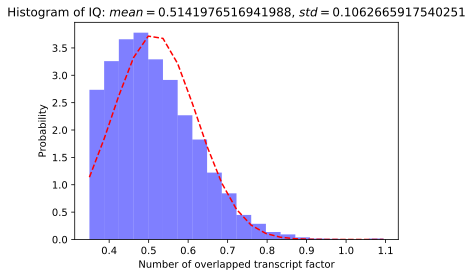

/data/software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/data/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


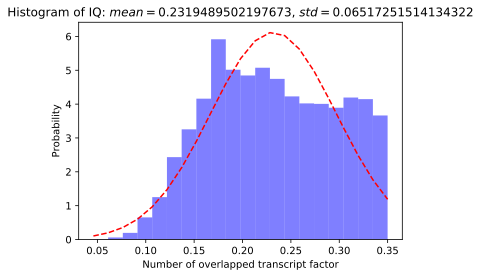

In [49]:
def get_genes_by_CpG():
    CpG_high = "/data5/galaxy/project/CpG_m6a_motif/fasta_seq/high_CpG.bed"
    CpG_low = "/data5/galaxy/project/CpG_m6a_motif/fasta_seq/low_CpG.bed"
    score_list = []
    for in_bed in [CpG_high, CpG_low]:
        df = pd.read_table(in_bed, sep="\t", header=None)
        score_list.append(df.iloc[:, 4])
    return score_list

def plot_histogram(data_list):
    num_bins, mean, std = 20, np.mean(data_list), np.std(data_list)
    n, bins, patches = plt.hist(data_list, num_bins, normed=1, facecolor="blue", alpha=0.5)
    y = mlab.normpdf(bins, mean, std)
    plt.plot(bins, y, "r--")
    plt.xlabel("Number of overlapped transcript factor")
    plt.ylabel("Probability")
    plt.title(r"Histogram of IQ: $mean=%s$, $std=%s$" % (str(mean), str(std)))
    plt.subplots_adjust(left=0.15)
    plt.show()

score_list = get_genes_by_CpG()
plot_histogram(score_list[0])
plot_histogram(score_list[1])